<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
</head>
<body>
    
<div style="font-family:Georgia" align="center">
<h1 align="center">Free Project - Technical Report</h1>
<h1 align="center"><span style="text-decoration: gray underline overline" >  Kuramoto Model
</span></span></h1>

<br>
<br>

<h3> By: </h3>
<h3> Niels Faucher </h3>


<br>
<br>

<h3> Supervisors :</h3>
<h3> Pr. Daniel BRUNNER,</h3>
<h3> Phd student Jacob PUHALO-SMITH & Dr. Anas SKALLI from the FEMTO-ST Institute </h3>
</div>
</body> 
</html>

### The reader is strongly encourage to read the report attached to this technical report
### If you encounter any difficulties or have questions, please do not hesitate to reach out to me at:
niels.faucher@edu.univ-fcomte.fr 

In this report, I explored the Kuramoto model as part of the Unite "Free project". My objective was to numerically "build" a neural network by simulating its behavior using the Kuramoto model as a foundational framework. I explored how this model can be used to study synchronization dynamics in coupled systems, particularly in vertical-cavity surface-emitting lasers (VCSELs). 

The project was divided into two main phases. In the first phase (alpha version), I constructed and tested the initial model to understand its behavior, and tested a upgraded version of the kuramoto model. The second phase (beta version) involved exploring how the system of oscillators depends on various parameters and investigating synchronization when an external input is introduced under specific conditions.  

__The user will find 3 main codes, each describe the basic Kuramoto model, the upgrade one, and the ugrade one with input signal.__

## I ) Alpha version

#### Description of the Code for the basic Kuramoto model

The code below implements the basic Kuramoto model and simulates its behavior over time. The goal is to understand how the oscillators synchronize under different conditions. We will quickly present the structure of the code, the needed imports librairies, but after we will describe everything direclty in the code in order to be more user friendy. For each function the user can find a detail description of the function, with parameters and ouput of the function.

The user will need to have, `numpy` and `matplotlib.pyplot`  librairies for the calculation and the plot, and `scipy` to have the solver `odeint`.

##### Code Structure
- **Imports and Parameters** : Setup initial configurations.
- **Initial Conditions**: Generate initial phases and frequencies.
---
- **Derivative Function** : Defines the differential equations for the Kuramoto model with external input.
- **Integration and Simulation** : Integrates the model using `odeint`.
- **Phase Coherence Calculation** : Computes phase coherence of oscillators.
---
- **Main Simulation Function** : Orchestrates the entire simulation process.


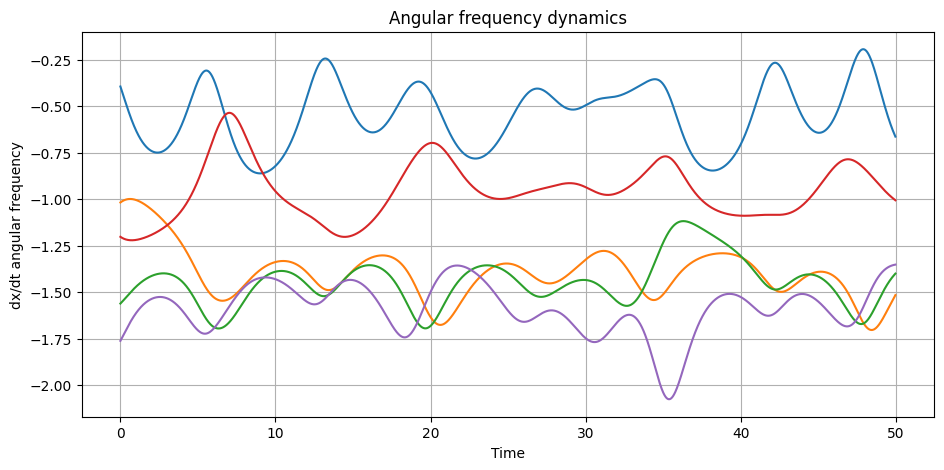

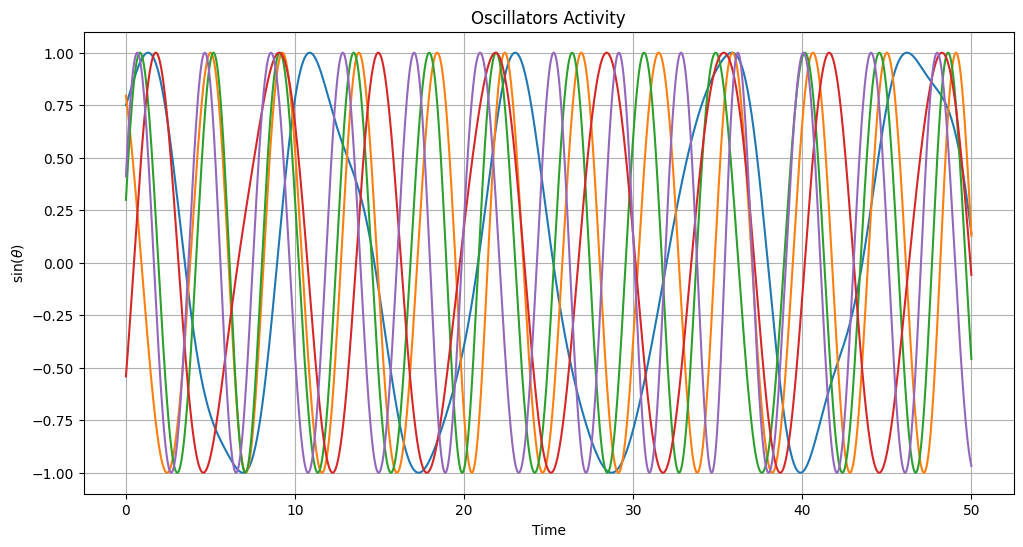

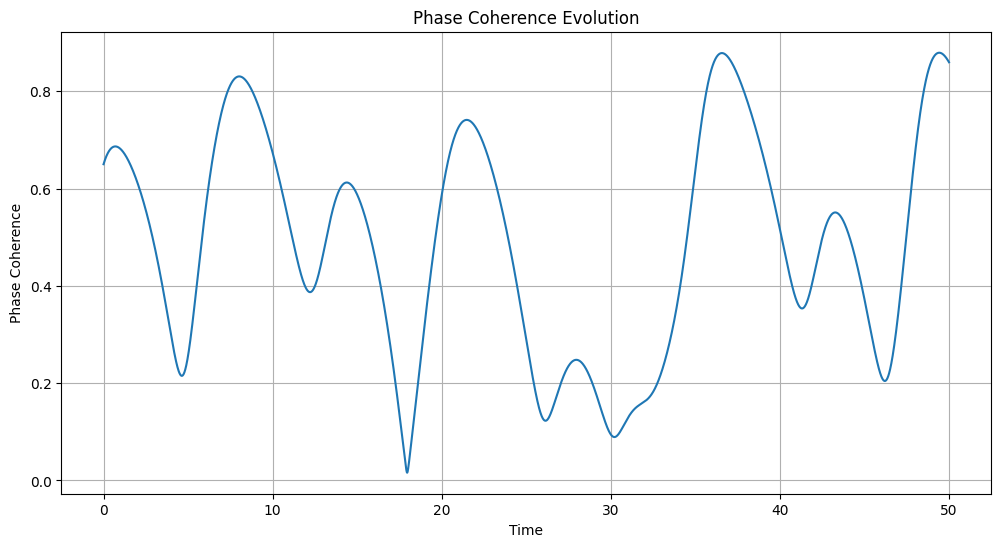

In [2]:
#=========================================================================================
#                            BASIC KURAMOTO MODEL
#=========================================================================================



#=================================== Librairies ======================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#==================================== Parameters =====================================================

N = 5  # Number of oscillators - Info : more oscillo equal more order
T = 50  # Total time of simulation 
dt = 0.01  # Time step 
alpha = 0.5  # Coupling strength - Example value : 0.5 = chaotic behavior, 1.5 = "order" behavior

#===================================== Initial Conditions ============================================

def init_frequencies_phases(N):
    """
    Initializes the natural frequencies and initial phases of the oscillators.
    
    Parameters:
        N (int): Number of oscillators
    
    Returns:
        omega (np.ndarray): Array containing the natural frequencies of the oscillators.
        initial_phases (np.ndarray): Array containing the initial phases of the oscillators, in radians.
    """
    # Generate a normal distribution for the natural frequencies with mean 1 and standard deviation 0.5
    omega = np.random.normal(1, 0.5, size=N)
    
    # Generate random initial phases between [0, 2π]
    initial_phases = 2 * np.pi * np.random.rand(N)
    
    return omega, initial_phases

#====================================== Derivative Function ===============================================

def kuramoto_derivative(angles_vec, t, omega, adj_mat, coupling):
    """
    Computes the time derivatives of the Kuramoto model equations.

    Parameters:
        angles_vec (np.ndarray): Array containing the current phases of the oscillators, in radians.
        t (float): Current time (included for compatibility with odeint).
        omega (np.ndarray): Array containing the natural frequencies of the oscillators.
        adj_mat (np.ndarray): Adjacency matrix representing connections between oscillators.
        coupling (float): The strength of coupling between oscillators.

    Returns:
        dxdt (np.ndarray): Array containing the time derivatives of the phases for each oscillator.
    """
    # Compute pairwise phase differences
    phase_diffs = angles_vec[:, None] - angles_vec

    # Compute interactions as the product of adjacency matrix and sine of phase differences
    interactions = adj_mat * np.sin(phase_diffs)

    # Normalize coupling strength by the number of oscillators
    coupling_normalized = coupling / N    
    
    # Calculate the time derivatives of the phases
    dxdt = omega + coupling_normalized * interactions.sum(axis=0)

    return dxdt


#======================================= Integration part ==================================================

def integrate_kuramoto(omega, initial_phases, adj_mat, coupling, T, dt):
    """
    Integrates the Kuramoto model equations to simulate the dynamics of coupled oscillators.
    
    Parameters:
        omega (np.ndarray): Array containing the natural frequencies of the oscillators.
        initial_phases (np.ndarray): Array containing the initial phases of the oscillators, in radians.
        adj_mat (np.ndarray): Adjacency matrix representing connections between oscillators.
        coupling (float): The strength of coupling between oscillators.
        T (float): Total time of simulation.
        dt (float): Time step size for integration.
        
    Returns:
        timeseries (np.ndarray): Array containing the state of the system at each time step.
        t (np.ndarray): Array representing time points at which the state is evaluated.
    """
    # Create a vector of time points
    t = np.linspace(0, T, int(T / dt))
    
    # Integrate the Kuramoto model using odeint from scipy.integrate
    timeseries = odeint(kuramoto_derivative, initial_phases, t, args=(omega, adj_mat, coupling))
    
    return timeseries.T, t

#======================================= Phase coherence calculation ==============================================

def calculate_phase_coherence(angles_vec):
    """
    Calculates the phase coherence of a set of angles.
    
    Parameters:
        angles_vec (np.ndarray): Array containing the phases of oscillators.
        
    Returns:
        coherence (float): The magnitude of the complex sum of exponentials, representing phase coherence.
    """
    # Sum of exponentials in the complex plane
    suma = sum([np.exp(1j * i) for i in angles_vec])
    
    # Phase coherence is the magnitude of this sum
    coherence = abs(suma / len(angles_vec))
    
    return coherence

def calculate_vector_sum(activity):
    """
    Calculates the vector sum (sum of sines) of a set of oscillator activities.
    
    Parameters:
        activity (np.ndarray): Array containing the states (phases or amplitudes) of oscillators over time.
        
    Returns:
        vector_sum (float): The vector sum of the sine values.
    """
    # Sum of sin(θ) for all oscillators
    vector_sum = np.sum(np.sin(activity), axis=0)
    
    return vector_sum

#========================================= Main simulation function ================================================

def run_simulation(N, alpha, T, dt):
    """
    Runs a full simulation of the Kuramoto model and plots relevant results.
    
    Parameters:
        N (int): Number of oscillators - This is the number of coupled oscillators in our simulation.
        alpha (float): Coupling strength - This controls how strongly the oscillators influence each other.
        T (float): Total time of simulation - The duration for which we will simulate the system.
        dt (float): Time step size for integration.
    """
    # Generate a random adjacency matrix with connections between oscillators
    adj_mat = (np.random.rand(N, N) < 1).astype(float)
    
    # Fill the diagonal of the adjacency matrix to zero as self-coupling is not allowed in this model
    np.fill_diagonal(adj_mat, 0)

    # Initialize parameters for the oscillators
    omega, initial_phases = init_frequencies_phases(N)
    
    # Integrate the Kuramoto model equations
    activity, t = integrate_kuramoto(omega, initial_phases, adj_mat, alpha, T, dt)

    # Calculate phase coherence over time
    phase_coherences = np.array([calculate_phase_coherence(activity[:, i]) for i in range(activity.shape[1])])
    
    # Calculate the vector sum of sine values as a measure of overall activity
    vector_sum = calculate_vector_sum(activity)

    # Plot angular frequency dynamics
    dx = (activity.T[0:-1] - activity.T[1:]) / dt
    plt.figure(figsize=(11, 5))
    for i in range(5):
        time = np.linspace(0, T - 2 * dt, int((T / dt) - dt))  # Time vector without the last point to avoid aliasing
        plt.title("Angular frequency dynamics")
        plt.plot(time, dx[:, i])
        plt.xlabel('Time')
        plt.ylabel('dx/dt angular frequency')
        plt.grid(True)
    plt.show()

    # Plot oscillators activity vs time with external force (sine wave)
    plt.figure(figsize=(12, 6))
    plt.plot(t, np.sin(activity.T), label="Oscillators Activity")
    plt.xlabel('Time')
    plt.ylabel(r'$\sin(\theta)$')  # Label in LaTeX format for sin(θ)
    plt.title("Oscillators Activity")
    plt.grid(True)
    plt.show()

    # Plot phase coherence evolution
    plt.figure(figsize=(12, 6))
    plt.plot(t, phase_coherences)
    plt.xlabel('Time')
    plt.ylabel('Phase Coherence')
    plt.title("Phase Coherence Evolution")
    plt.grid(True)
    plt.show()

# Run the Simulation
run_simulation(N, alpha, T, dt)

## I ) Alpha version & II ) Beta version
__We remind the user that the following code served us to complete the alpha version (upgraded kuramoto) and start the beta version (parameters testing)__ 

#### Description of the Code for the Upgraded Kuramoto Model

This code follows the same structure as the basic Kuramoto model presented earlier, with some upgrades to the governing equations. Specifically, we have introduced a coupling matrix, which allows for a more complex interaction between oscillators. The user is encouraged to consult **Equation 5** in the corresponding scientific report for a deeper understanding of these modifications.

We will maintain the same approach of describing the structure of the code at a high level and then providing detailed inline comments for user-friendly navigation. To avoid overloaded the code we will detailed description of each functions, explaining its parameters, output, and purpose but only when we added something new.

The required Python libraries are:
- `numpy` for numerical computations,
- `matplotlib.pyplot` for visualization,
- `scipy` for advanced mathematical functions, such as the solver `odeint`.

##### Code Structure
- **Imports and Parameters**: Sets up the libraries and global parameters for the simulation.
- **Initial Conditions**: Initializes random phases for the oscillators.
---
- **Differential Equation**: Defines the Kuramoto model with a coupling matrix, as described in the report.
- **Integration**: Uses `odeint` to solve the system of differential equations over time.
- **Phase Coherence**: Computes the global phase coherence \( R_t \) of the oscillators.
---
- **Results Analysis**: Contains functions for analyzing and visualizing the effects of key parameters, such as the coupling strength, network size, and adjacency matrix density.
- **Fitting Models**: Provides utilities to fit observed trends to mathematical models (e.g., power-law, linear).
---
- **Main Simulation and Visualization**: Brings together all components to simulate the upgraded Kuramoto model and analyze the results under various configurations.

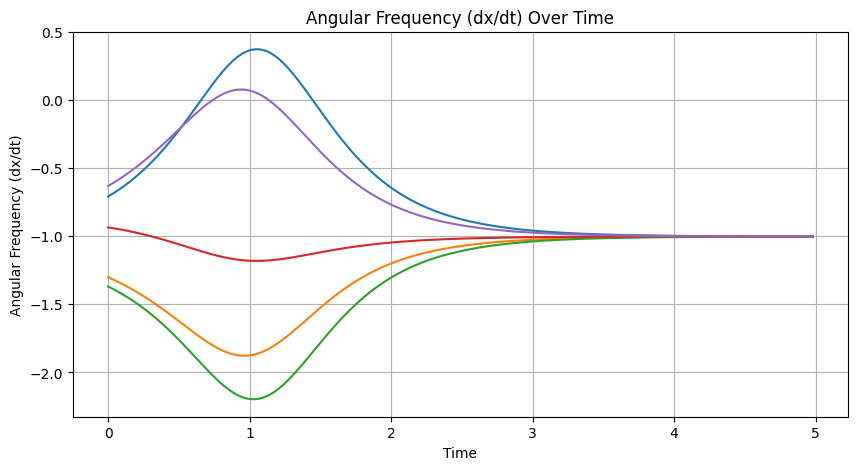

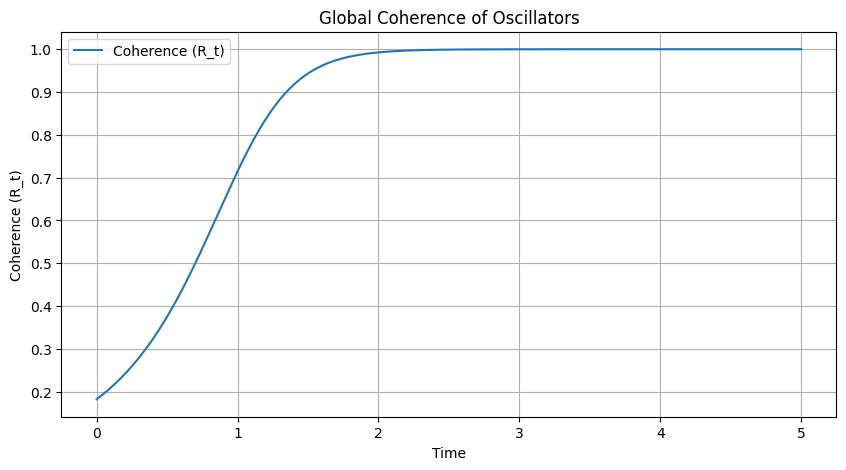

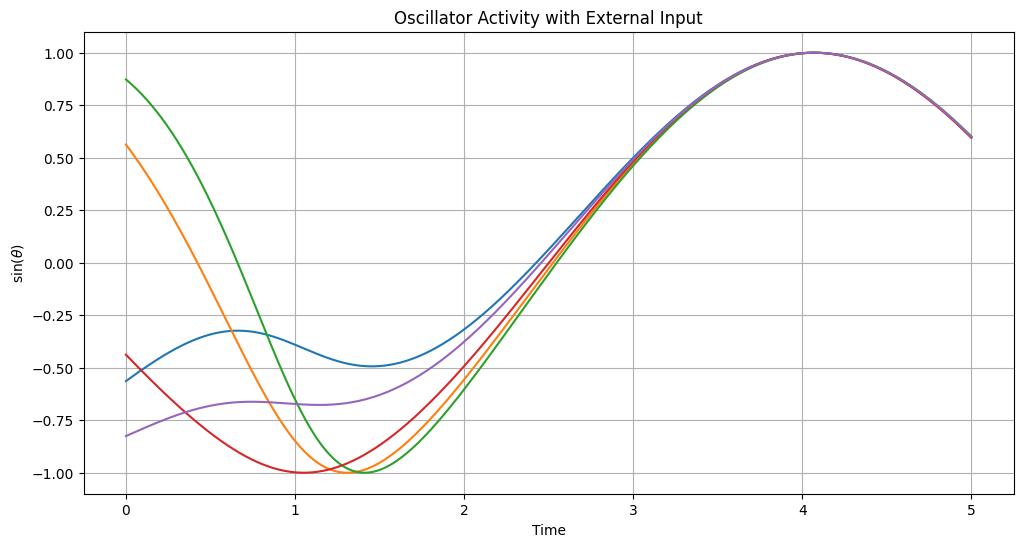

Fitted parameters: a = 0.141, b = -0.926


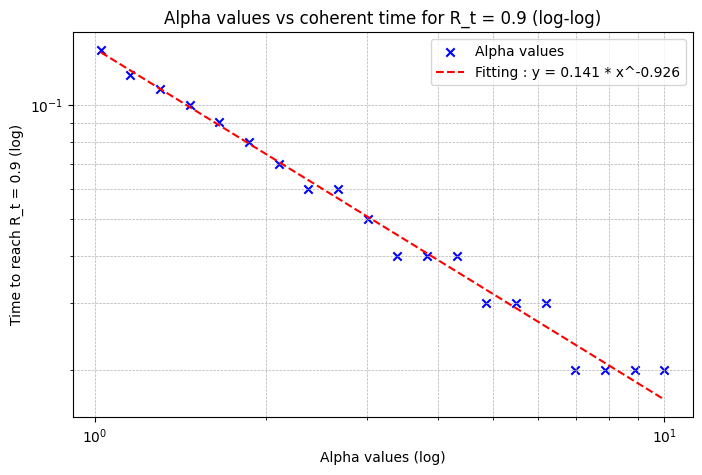

In [22]:
#=========================================================================================
#                            UPGRADED KURAMOTO MODEL
#=========================================================================================



#=================================== Librairies ======================================================
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.optimize import curve_fit

np.random.seed(4)  # it's really important to keep the seed if you plan to use th code as it is because we will need it for some analysis.

#===================================== Initial Phases ============================================

# These phases will be use in the last part "if main..." to run the code

def init_angles(n_nodes):
    """Initialization of random phases between [0, 2π]."""
    return 2 * np.pi * np.random.random(size=n_nodes)

#====================================== Derivative Function ===============================================

def derivative(angles_vec, t, K, natfreqs):
    """
    Calculates the derivatives of the oscillator phases according to the upgraded Kuramoto model.
    
    Parameters:
        angles_vec (np.ndarray): Array of current phases of the oscillators.
        t (float): Current time (not explicitly used in the calculation but included for compatibility with odeint).
        K (np.ndarray): Coupling matrix, where each element K[i, j] represents the strength of the interaction between oscillators i and j.
        natfreqs (np.ndarray): Array of natural frequencies of the oscillators.
    
    Returns:
        dxdt (np.ndarray): Array of phase derivatives for each oscillator.
    """
    # Create grids of all-to-all phase differences
    angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
    
    # Compute pairwise interaction term K_ij * sin(angles_j - angles_i)
    # adj_mat ensures only connected oscillators are considered
    interactions = adj_mat @ K @ np.sin(angles_j - angles_i)
    
    # Sum the interactions for each oscillator and scale by the global coupling factor alpha
    dxdt = natfreqs + alpha * interactions.sum(axis=0)
    
    return dxdt


#======================================= Integration part ==================================================

def integrate(angles_vec, K, natfreqs, t, dt):
    """
    Integrates the Kuramoto equations over a given time period.
    
    Parameters:
        angles_vec (np.ndarray): Initial phases of the oscillators.
        K (np.ndarray): Coupling matrix defining the interaction strengths between oscillators.
        natfreqs (np.ndarray): Natural frequencies of the oscillators.
        t (float): Total simulation time.
        dt (float): Time step for the simulation.
    
    Returns:
        t (np.ndarray): Array of time points where the simulation was evaluated.
        timeseries (np.ndarray): Transposed array of oscillator phases over time, where rows represent oscillators and columns represent time steps.
    """
    # Generate a time array from 0 to T with steps of dt
    t = np.linspace(0, T, int(T / dt))
    
    # Solve the differential equations using odeint
    timeseries = odeint(derivative, angles_vec, t, args=(K_norm, natfreqs))
    
    # Return the time array and the transposed phase timeseries
    return t, timeseries.T


#======================================= Calculation coherence ==================================================

def phase_coherence(angles_vec):
    """Compute the coherence global of phases"""
    suma = sum([(np.e ** (1j * i)) for i in angles_vec])
    return abs(suma / len(angles_vec))

def time_to_reach_coherence(coherence_series, t, target=0.9):
    """
    Determines the time required for the global coherence to reach a target value.
    If the target is never reached, returns np.nan.
    
    Parameters:
        coherence_series (np.ndarray): Time series of global coherence values (R_t).
        t (np.ndarray): Array of time points corresponding to the coherence_series.
        target (float): The target coherence value to detect (default is 0.9).
    
    Returns:
        float: The time at which the target coherence is first reached, or np.nan if not reached.
    """
    for i, coherence in enumerate(coherence_series):
        if coherence >= target:  # Check if coherence exceeds or equals the target
            return t[i]  # Return the corresponding time point
    return np.nan  # If the target coherence is never reached



#======================================= Results Visualization =============================================

def plot_results(t, timeseries, coherence_series):
    """
    Plots the results of the Kuramoto model integration.
    
    Parameters:
        t (np.ndarray): Array of time points.
        timeseries (np.ndarray): Phase timeseries of oscillators (rows: oscillators, columns: time points).
        coherence_series (np.ndarray): Time series of the global phase coherence (R_t).
    """
    # Number of oscillators
    n_nodes = timeseries.shape[0]
    
    # Compute the angular frequencies (dx/dt)
    dx = (timeseries.T[:-1] - timeseries.T[1:]) / dt
    
    # Plot angular frequencies over time
    plt.figure(figsize=(10, 5))
    for i in range(n_nodes):
        time = np.linspace(0, T - 2 * dt, int((T / dt) - dt))
        plt.title("Angular Frequency (dx/dt) Over Time")
        plt.plot(time, dx[:, i])
    plt.xlabel("Time")
    plt.ylabel("Angular Frequency (dx/dt)")
    plt.grid()
    plt.show()

    # Plot global coherence over time
    plt.figure(figsize=(10, 5))
    plt.plot(t, coherence_series, label="Coherence (R_t)")
    plt.title("Global Coherence of Oscillators")
    plt.xlabel("Time")
    plt.ylabel("Coherence (R_t)")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot oscillator activity (sin of phases)
    plt.figure(figsize=(12, 6))
    plt.plot(t, np.sin(timeseries.T), label="Oscillators Activity")
    plt.xlabel('Time')
    plt.ylabel(r'$\sin(\theta)$')
    plt.title("Oscillator Activity with External Input")
    plt.grid()
    plt.show()

#========================================= Fitting Models================================
#Curve fitting models for Parameters Analysis:

def power_law(x, a, b):
    """Model of power law : y = a * x^b."""
    return a * x**b

def linear_fit(x, a, b):
    """Model of linear law : y = a * x+b."""
    return a * x + b

def exponential_fit(x, a, b):
    """Model of exponential law : y = a * exp(x*b)."""
    return a * np.exp(b * x)

#========================================== Parameter Analysis ========================

# We examines the effect of the number of oscillators (n_nodes), the matrix adajency (matrix_adj),
# the scaling factor (alpha_value) and finally the std of the natural frequency (natfreq_delta) on 
# the time to reach coherence (here we set up the coherence at 0.9). 
# 
# Here we decided to run the simulation for differents values and see if they fit some of the laws 
# we defined above, like that we could gain some information of how the system behave under certains values.

def visualize_effect_of_n_nodes():
    """Visualizes the effect of varying the number of oscillators (n_nodes) on the system."""
    n_nodes_values = [3,5,7,8,10,11,13,15,17,20] # Different numbers of oscillators to test
    times_to_reach_coherence = []

    for n in n_nodes_values:
        global n_nodes, natfreqs, adj_mat, K_norm, angles_vec
        n_nodes = n
        natfreqs = np.random.normal(1, natfreq_delta, size=n_nodes)  # Update natural frequencies
        adj_mat = (np.random.rand(n_nodes, n_nodes) < matrix_adj).astype(float)
        np.fill_diagonal(adj_mat, 0)

        K = np.random.uniform(0, 1, size=(n_nodes, n_nodes))
        np.fill_diagonal(K, 1)
        eigenvalues, eigenvectors = la.eig(K)
        max_eigen = np.max(np.real(eigenvalues))
        K_norm = K / max_eigen
        angles_vec = init_angles(n_nodes)

        t, timeseries = integrate(angles_vec, K_norm, natfreqs, T, dt)
        coherence_series = [phase_coherence(timeseries[:, i]) for i in range(timeseries.shape[1])]
        time = time_to_reach_coherence(coherence_series, t)
        times_to_reach_coherence.append(time)

    # Log-log plot and power-law fit
    n_array = np.array(n_nodes_values)
    times_array = np.array(times_to_reach_coherence)
    popt, _ = curve_fit(power_law, n_array, times_array)
    a_fit, b_fit = popt
    #Plot
    print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}")
    plt.figure(figsize=(8, 5))
    plt.scatter(n_array, times_array, color='blue',marker='x', label="Number of nodes")
    plt.plot(n_array, power_law(n_array, *popt), color='red', linestyle='--', label=f"Fitting : y = {a_fit:.3f} * x^{b_fit:.3f}")
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Number of nodes vs coherent time for R_t = 0.9 (log-log)")
    plt.xlabel("Number of nodes (log)")
    plt.ylabel("Time to reach R_t = 0.9 (log)")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.show()

def visualize_effect_of_matrix_adj():
    """Visualizes the effect of varying matrix_adj on the system."""
    matrix_adjs = np.linspace(0.5,0.9,10)
    print(matrix_adjs)
    times_to_reach_coherence = []

    for ma in matrix_adjs:
        global adj_mat
        adj_mat = (np.random.rand(n_nodes, n_nodes) < ma).astype(float)
        np.fill_diagonal(adj_mat, 0)
        t, timeseries = integrate(angles_vec, K_norm, natfreqs, T, dt)
        coherence_series = [phase_coherence(timeseries[:, i]) for i in range(timeseries.shape[1])]
        time = time_to_reach_coherence(coherence_series, t)
        times_to_reach_coherence.append(time)

    # Log-log plot and power-law fit
    adj_array = np.array(matrix_adjs)
    times_array = np.array(times_to_reach_coherence)
    print(times_array)
    popt, _ = curve_fit(linear_fit, adj_array, times_array)
    a_fit, b_fit = popt
    print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(adj_array, times_array, color='blue',marker='x', label="% of filling the Adjacency matrix")
    plt.plot(adj_array, linear_fit(adj_array, *popt), color='red', linestyle='--', label=f"Fitting : y = {a_fit:.3f} * x + {b_fit:.3f}")
    # plt.xscale('log')
    # plt.yscale('log')
    plt.title("Filling of the Adjacency matrix vs coherent time for R_t = 0.9 (linear)")
    plt.xlabel("Adjacency matrix %")
    plt.ylabel("Time to reach R_t = 0.9")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.show()

def visualize_effect_of_alpha():
    """Visualizes the effect of varying alpha on the system."""
    alphas = np.logspace(0.01, 1, 20)
    times_to_reach_coherence = []

    for a in alphas:
        global alpha
        alpha = a
        t, timeseries = integrate(angles_vec, K_norm, natfreqs, T, dt)
        coherence_series = [phase_coherence(timeseries[:, i]) for i in range(timeseries.shape[1])]
        time = time_to_reach_coherence(coherence_series, t)
        times_to_reach_coherence.append(time)

    # Log-log plot and power-law fit
    alpha_array = np.array(alphas)
    times_array = np.array(times_to_reach_coherence)
    popt, _ = curve_fit(power_law, alpha_array, times_array)
    a_fit, b_fit = popt
    print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(alpha_array, times_array, marker ='x',color='blue', label="Alpha values")
    plt.plot(alpha_array, power_law(alpha_array, *popt), color='red', linestyle='--', label=f"Fitting : y = {a_fit:.3f} * x^{b_fit:.3f}")
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Alpha values vs coherent time for R_t = 0.9 (log-log)")
    plt.xlabel("Alpha values (log)")
    plt.ylabel("Time to reach R_t = 0.9 (log)")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.show()

def visualize_effect_of_natfreq_delta():
    """Visualizes the effect of varying natfreq_delta on the system."""
    natfreq_deltas = np.linspace(1e-4,1e-2,20)#[0.001,0.003,0.007,0.01,0.03,0.07,0.1]  # Different values of natfreq_delta to test
    print(natfreq_deltas)
    times_to_reach_coherence = []

    for delta in natfreq_deltas:
        global natfreqs, angles_vec, K_norm, n_nodes
        natfreqs = np.random.normal(1, delta, size=n_nodes)  # Update natural frequencies
        t, timeseries = integrate(angles_vec, K_norm, natfreqs, T, dt)
        coherence_series = [phase_coherence(timeseries[:, i]) for i in range(timeseries.shape[1])]
        time = time_to_reach_coherence(coherence_series, t)
        times_to_reach_coherence.append(time)

    # Log-log plot and power-law fit
    delta_array = np.array(natfreq_deltas)
    times_array = np.array(times_to_reach_coherence)
    # popt, _ = curve_fit(linear_fit, delta_array, times_array)
    # a_fit, b_fit = popt

    # Print the fitting parameters
    # print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(delta_array, times_array, marker='x',color='blue', label="Std values (Nat_Freq)")
    # plt.plot(delta_array, linear_fit(delta_array, *popt), color='red',linestyle='--', label=f"Ajustement : y = {a_fit:.3f} * x^{b_fit:.3f}")
    # plt.xscale('log')
    # plt.yscale('log')
    plt.title("STD of the natural frequency vs coherent time for R_t = 0.9")
    plt.xlabel("Values of std (Nat_Freq)")
    plt.ylabel("Time to reach R_t = 0.9")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.show()


#========================================= Main simulation function ================================================

if __name__ == "__main__":

    # Parameters of the simulation
    n_nodes = 5             # Numbers of oscillators
    T = 5                   # Total time of the simulation
    dt = 0.01               # Time step
    alpha = 0.1             # Scaling factor 
    natfreq_delta = 0.01    # STD of the natural frequency
    matrix_adj = 0.9        # Filling of the adajency matrix (for moree details see the scientific report)

    # Inititalisation of the values 

    natfreqs = np.random.normal(1, natfreq_delta, size=n_nodes)             # Natural frequencies
    adj_mat = (np.random.rand(n_nodes, n_nodes) < matrix_adj).astype(float) # Adajency matrix
    np.fill_diagonal(adj_mat, 1)                                            # Filling the diagonal of 1 of the adj_matrix for the self coupling

    K = np.random.uniform(0, 1, size=(n_nodes, n_nodes))                    # Coupling matrix
    np.fill_diagonal(K, 1)                                                  # Filling the diagonal of 1 of the K

    eigenvalues, eigenvectors = la.eig(K)
    max_eigen = np.max(np.real(eigenvalues))
    K_norm = K / max_eigen                                                  # Normalization of the coupling matrix by the largest eigenvalue

    angles_vec = init_angles(n_nodes)                                       # Initialization of phases
    t, timeseries = integrate(angles_vec, K_norm, natfreqs, T, dt)          # Integration
    coherence_series = [phase_coherence(timeseries[:, i]) for i in range(timeseries.shape[1])] #Computation coherence
    
    # Plot : Results visualization

    plot_results(t, timeseries, coherence_series)

    # Plot : Parameters Analysis
    # !!!! IMPORTANT INFO !!!!! # In order to have accurate results 
    # !!!! the user cannot plot all the following graphs at the same time, only one at a time can be plot

    visualize_effect_of_alpha()
    # visualize_effect_of_matrix_adj()
    # visualize_effect_of_n_nodes()
    # visualize_effect_of_natfreq_delta()




## II ) Beta version
#### Description of the Code for the Upgraded Kuramoto Model with a Input signal

This code follows the same structure as the upgraded Kuramoto model presented above, the main difference is that we implemented a input signal. THe main goal here is to study if and how we can lock the phases of our system (oscillators) with a input phase. The user is encouraged to consult **Equation 6** in the corresponding scientific report for a deeper understanding of these modifications.

We will maintain the same approach of describing the structure of the code then providing detailed inline comments for user-friendly navigation. To avoid overloaded the code we will detailled description of each functions, explaining its parameters, output, and purpose but only when we added something new.

The required Python libraries are:
- `numpy` for numerical computations,
- `matplotlib.pyplot` for visualization,
- `scipy` for advanced mathematical functions, such as the solver `odeint`.

##### Code Structure
- **Imports and Parameters**: Sets up the libraries and global parameters for the simulation.
- **Initial Conditions**: Initializes random phases for the oscillators.
---
- **Differential Equation**: Defines the Kuramoto model with a coupling matrix, as described in the report.
- **Integration**: Uses `odeint` to solve the system of differential equations over time.
- **Phase Coherence**: Computes the global phase coherence \( R_t \) of the oscillators.
---
- **Results Analysis**: Contains functions for analyzing and visualizing the effects of key parameters, such as the coupling strength, network size, and adjacency matrix density.
- **Fitting Models**: Provides utilities to fit observed trends to mathematical models (e.g., power-law, linear).
---
- **Main Simulation and Visualization**: Brings together all components to simulate the upgraded Kuramoto model and analyze the results under various configurations.

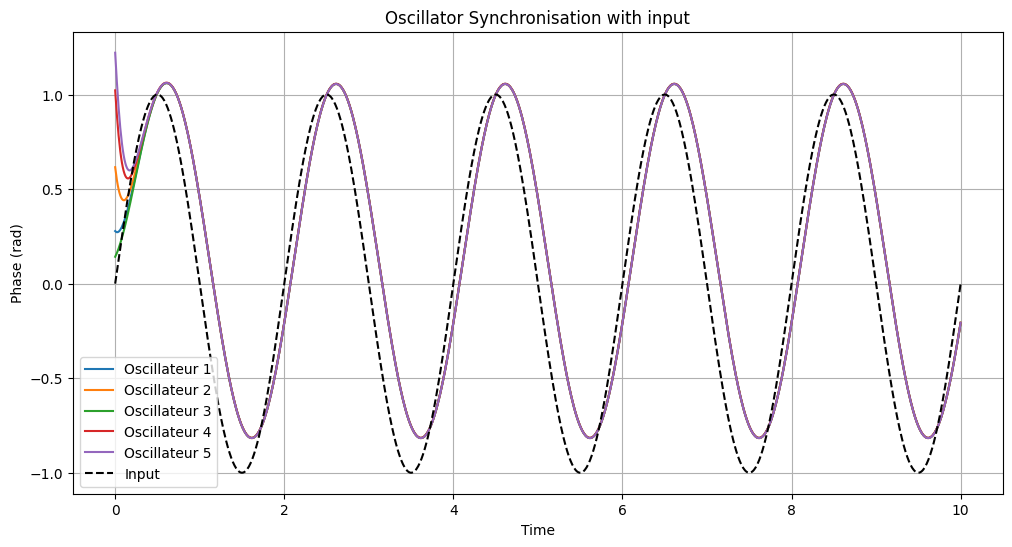

Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...
Comptation of the PLV Heatmap in progress...

----Computation of the PLV Heatmap is finished !----


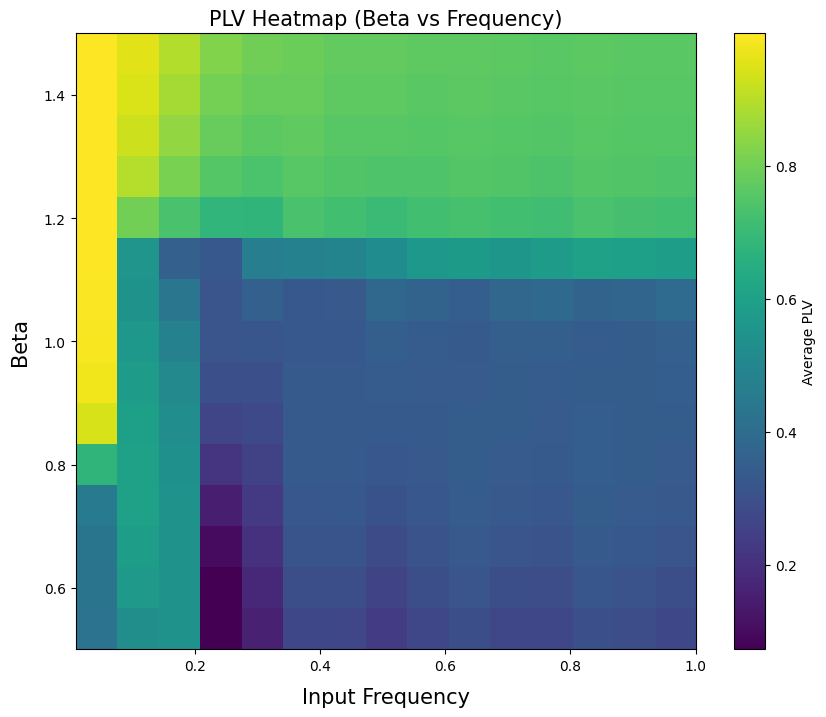

In [ ]:
#=========================================================================================
#                            UPGRADED KURAMOTO MODEL WITH INPUT SIGNAL
#=========================================================================================



#========================================= Librairies ==============================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy import linalg as la

np.random.seed(42)

#====================================== Initialization ==============================================

def init_angles(n_nodes):
    """Initialization of random phases between [0, 2π]."""
    return 1* np.pi * np.random.random(size=n_nodes)

def input_signal(t, freq_input, amplitude, phase_shift):
    """"
    Generates an input oscillator signal.
    Parameters:
        t (float): Time at which to evaluate the signal.
        freq_input (float): Natural frequency of the input oscillator.
        amplitude (float): Amplitude modulation of the input signal.
        phase_shift (float): Initial phase shift of the input signal.
    Returns:
        float: Value of the input signal at time t.
    """
    return amplitude * np.sin(2 * np.pi * freq_input * t + phase_shift)

#====================================== Derivative Function ===========================================

def derivative_with_input(angles_vec, t, K, natfreqs, freq_input, input_amplitude):
    """
    Calculates the derivatives of the phase angles with the influence of an input oscillator.
    Parameters:
        angles_vec (numpy.ndarray): Array of current phase angles.
        t (float): Current time.
        K (numpy.ndarray): Coupling matrix.
        natfreqs (numpy.ndarray): Natural frequencies of the oscillators.
        freq_input (float): Frequency of the input oscillator.
        input_amplitude (float): Amplitude of the input oscillator's influence.
    Returns:
        numpy.ndarray: Array of derivatives of the phase angles.
    """
    angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
    interactions = adj_mat @ K @ np.sin(angles_j - angles_i)                    # Initial Interaction term
    
    # Input signal phase
    input_phase = input_signal(t, freq_input, input_amplitude, phase_shift=0)   # Input signal
    input_interaction = beta* np.sin(input_phase - angles_vec)                  # Input influence
    
    dxdt = natfreqs + alpha * interactions.sum(axis=0) + input_interaction
    return dxdt

#============================================ Integration part =================================================

def integrate_with_input(angles_vec, K, natfreqs, T, dt, freq_input, input_amplitude):
    """
    Integrates the system of equations with an input oscillator.
    Parameters:
        angles_vec (numpy.ndarray): Initial phase angles.
        K (numpy.ndarray): Coupling matrix.
        natfreqs (numpy.ndarray): Natural frequencies of the oscillators.
        T (float): Total simulation time.
        dt (float): Time step for integration.
        freq_input (float): Frequency of the input oscillator.
        input_amplitude (float): Amplitude of the input oscillator's influence.
    Returns:
        tuple: Time array and timeseries of phase angles.
    """
    t = np.linspace(0, T, int(T / dt))
    timeseries = odeint(
        derivative_with_input,
        angles_vec,
        t,
        args=(K, natfreqs, freq_input, input_amplitude)
    )
    return t, timeseries.T  

#======================================= Results Visualization =============================================

#I this part we plot the phase of all the oscillators and the input, it will serve to see 
# if the oscillators lock in their phases with the one of the input.

def plot_sync_with_input(t, timeseries, input_phases):
    """
    Plots the phases of oscillators and the input signal to evaluate synchronization.
    Parameters:
        t (numpy.ndarray): Time array.
        timeseries (numpy.ndarray): Timeseries of oscillator phases.
        input_phases (numpy.ndarray): Timeseries of input phases.
    """
    n_nodes = timeseries.shape[0]
    plt.figure(figsize=(12, 6))
    
    # Plot oscillator phases
    for i in range(n_nodes):                                           
        plt.plot(t, timeseries[i], label=f'Oscillateur {i+1}')
    
    # Plot input phase
    plt.plot(t, input_phases, label='Input', linestyle='--', color='black')
    plt.title("Oscillator Synchronisation with input")
    plt.xlabel("Time")
    plt.ylabel("Phase (rad)")
    plt.legend()
    plt.grid()
    plt.show()

#======================================= Computation of the PLV for the Heat map =============================================

# Here we compute the vlaue of the PLV (Phase Locking Value) for each oscillator with the input and then we do the average
# For more detailles the user can see the --equations 8 & 9-- of the associate report.

def calculate_plv(timeseries, input_phases):
    """
    Calculates the Phase Locking Value (PLV) between each oscillator and the input signal.
    Parameters:
        timeseries (numpy.ndarray): Timeseries of oscillator phases.
        input_phases (numpy.ndarray): Timeseries of input phases.
    Returns:
        float: Average PLV across all oscillators.
    """
    n_nodes, n_timesteps = timeseries.shape
    plvs = []

    for i in range(n_nodes):
        # Phase difference for the current oscillator and the input
        phase_diff = timeseries[i, :] - input_phases
        
        # Complex exponential of the phase differences
        plv = np.abs(np.mean(np.exp(1j * phase_diff)))
        
        # Append the PLV of this oscillator
        plvs.append(plv)
    
    # Average PLV across all oscillators
    avg_plv = np.mean(plvs)
    return avg_plv

#========================================= Main simulation function ================================================

if __name__ == "__main__":

    # Parameters of the simulation
    n_nodes = 5             # Numbers of oscillators
    T = 10                  # Total time of the simulation
    dt = 0.01               # Time step
    alpha = 0.1             # Scaling factor for oscillators
    beta = 8.5              # Scaling factor for the input
    natfreq_delta = 0.01    # STD of the natural frequency
    matrix_adj = 0.9        # Filling of the adajency matrix (for moree details see the scientific report)

    
    # Inititalisation of the values 

    freq_input = 0.5                        # Natural frequency of the input
    input_amplitude = 1                     # Amplitude of the input
    
    natfreqs = np.random.normal(1, natfreq_delta, size=n_nodes)                     # Natural frequencies oscillators       
    adj_mat = (np.random.rand(n_nodes, n_nodes) < matrix_adj).astype(float)         # Adajency matrix                                            
    np.fill_diagonal(adj_mat, 1)                                                    # Filling the diagonal of 1 of the adj_matrix for the self coupling

    
    K = np.random.uniform(0, 1, size=(n_nodes, n_nodes))                            # Coupling matrix
    np.fill_diagonal(K, 1)                                                          # Filling the diagonal of 1 of the K

    
    eigenvalues, eigenvectors = la.eig(K)
    max_eigen = np.max(np.real(eigenvalues))
    K_norm = K / max_eigen                                                          # Normalization of the coupling matrix by the largest eigenvalue

    
    angles_vec = init_angles(n_nodes)                                                # Initialize phases
    t, timeseries = integrate_with_input(angles_vec, K_norm, natfreqs, T, dt, freq_input, input_amplitude)  # Integration
    input_phases = [input_signal(ti, freq_input, input_amplitude, phase_shift=0) for ti in t]  # Initialize phases for the input 

    # Plot of the Phases vs Time
    plot_sync_with_input(t, timeseries, input_phases)

    # Loop to compute the PLV
    beta_values = np.linspace(0.5,1.5 , 15)                 # Range of scaling factor input
    freq_values = np.linspace(0.01, 1, 15)                  # Range of frequencies input
    
    # Initialize 2D array to store PLV values
    plv_matrix = np.zeros((len(beta_values), len(freq_values)))
    for i, beta in enumerate(beta_values):
        for j, freq_input in enumerate(freq_values):
            # Integrate the system
            t, timeseries = integrate_with_input(
                angles_vec, K_norm, natfreqs, T, dt, freq_input, input_amplitude
            )
            
            # Generate input phases
            input_phases = [
                input_signal(ti, freq_input, input_amplitude, phase_shift=0) for ti in t
            ]
            
            # Calculate PLV for this (beta, freq_input) pair
            avg_plv = calculate_plv(timeseries, input_phases)
            
            # Store in the matrix
            plv_matrix[i, j] = avg_plv
        print("Comptation of the PLV Heatmap in progress...")
    print()
    print("----Computation of the PLV Heatmap is finished !----")

    
    
    #Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(plv_matrix, aspect='auto', origin='lower', 
            extent=[freq_values[0], freq_values[-1], beta_values[0], beta_values[-1]], cmap='viridis')
    plt.colorbar(label='Average PLV')
    plt.title("PLV Heatmap (Beta vs Frequency)",fontsize=15)
    plt.xlabel("Input Frequency",fontsize=15,labelpad=10)
    plt.ylabel("Beta",fontsize=15,labelpad=10)
    plt.grid(False)  # Optional, to make it cleaner
    plt.show()
